# Wavelet Attribution Method (WAM) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabrielkasmi/wam/blob/main/wam_example.ipynb)

This notebook shows how to use the Wavelet Attribution Method (WAM) to visualize what scales matter most to a model's predictions. For the full technical details, check out [our paper](https://openreview.net/forum?id=njZ5oVPObS) or the [project repository](https://github.com/gabrielkasmi/wam).

In [68]:

# Libraries imports
from pathlib import Path

import os
import torchvision
import torch
from lib.wam_2D import WaveletAttribution2D
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.viewers import plot_wam

from plot_utils import visualize_explanations_basic, plot_diagonal, visualize_gradients_at_levels
from utils import get_diagonal, get_explanations_for_image, get_gradients_attribution_on_levels, get_mean_across_images, get_multiple_grad_attr

device = "cuda" if torch.cuda.is_available() else "cpu"


In [81]:
def plot_grayscale_img(x: np.ndarray):
    plt.imshow(x, cmap='gray')
    plt.axis('off')
    plt.show()
    
def plot_img(x: np.ndarray):
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
def get_highest_percentage(gray: np.ndarray, percentage: float):
    flat = gray.flatten()
    sorted_indices = np.argsort(flat)[::-1]
    num_pixels = int(len(flat) * percentage)
    threshold_index = sorted_indices[num_pixels - 1]
    threshold_value = flat[threshold_index]
    mask = gray >= threshold_value
    return mask

def iou(mask1: np.ndarray, mask2: np.ndarray):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union != 0 else 0
    return iou


def get_grad_reprojection(explanation: np.ndarray, explainer, levels: int, wavelet: str, method: str):
    explanation = explanation.reshape((1, 224, 224))
    out = explainer.reproject_wam(explanation, levels)
    out = out.mean(axis=1).squeeze()
    return out

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(280),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# 3. Model 3: CNN convnext_tiny
convnext = torchvision.models.convnext_tiny(weights=torchvision.models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
convnext.eval()
convnext.to(device)


In [ ]:
wavelets = ['haar', 'db4', 'sym4', 'sym8']
LEVELS = 3
METHOD = "integratedgrad"

DATA_FOLDER = Path('data/weasel')
imgs = [Image.open(f) for f in DATA_FOLDER.iterdir()]


In [ ]:
def get_iou_between_wavelets(img, wavelets, p):
    
    # calculate reprojections for all wavelets
    reprojections = []
    for wave in wavelets:
        explainer = WaveletAttribution2D(convnext,
                                        wavelet=wave,
                                        J=LEVELS,
                                        method=METHOD,
                                        mode="reflect")
        
        expl = get_explanations_for_image(img, convnext, explainer, transform, device, 3)
        reprojections.append(get_grad_reprojection(expl, explainer, LEVELS, wave, METHOD))
    
    # get masks with highest percentage
    masks = []
    for repr in reprojections:
        mask = get_highest_percentage(repr, p)
        masks.append(mask)

    # calculate mean iou
    iou_values = []
    n = len(masks)
    for i in range(n):
        for j in range(i + 1, n):
            iou_val = iou(masks[i], masks[j])
            iou_values.append(iou_val)
    return np.mean(iou_values)    

In [ ]:
import pandas as pd

percentages = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
results = {}
for p in percentages:
    mean_iou_images = []
    for img in imgs:
        mean_iou = get_iou_between_wavelets(img, wavelets, p)
        mean_iou_images.append(mean_iou)
    results[p] = float(np.mean(mean_iou_images).round(3))
    
df_iou = pd.DataFrame(list(results.items()), columns=['percentage', 'mean_iou'])
df_iou.to_csv('results/iou.csv', index=False)

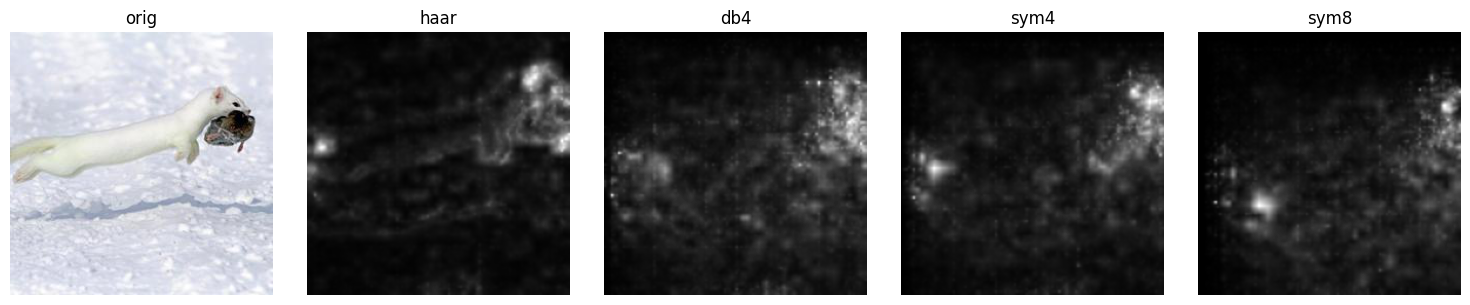

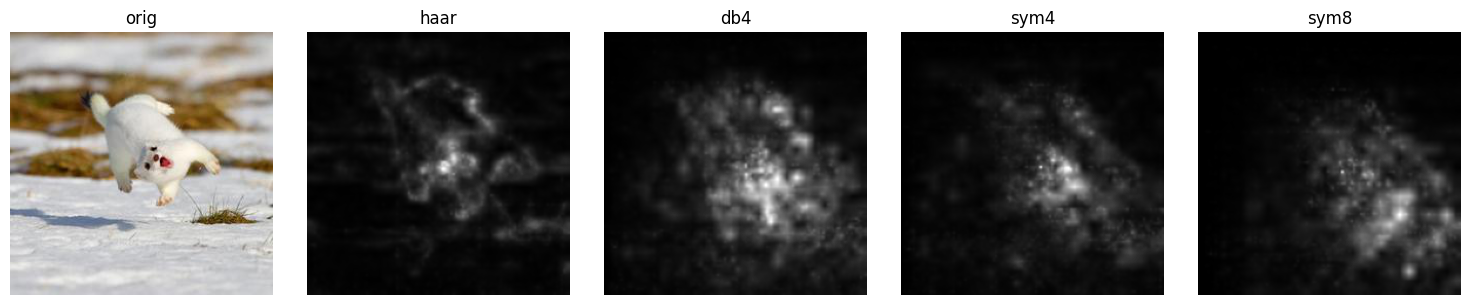

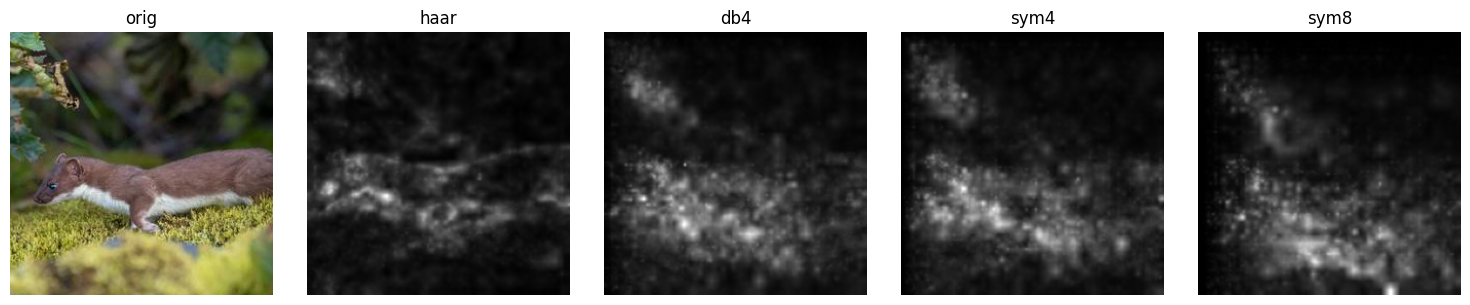

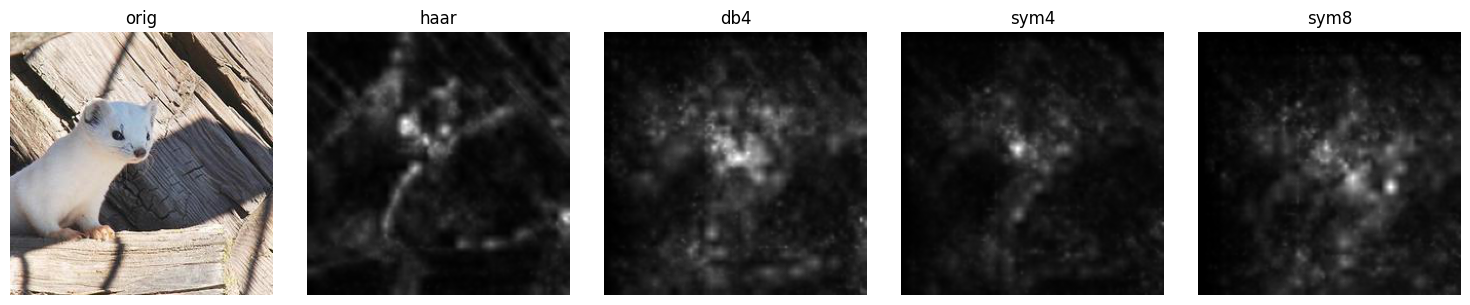

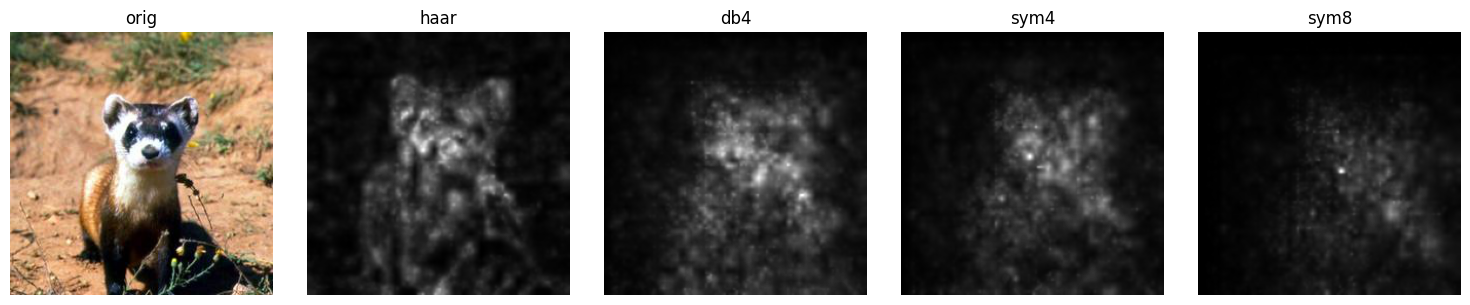

In [123]:
def plot_images_horizontally(imgs: list, subtitles: list = None, out: str = None):
    n = len(imgs)
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if imgs[i].ndim == 2:
            plt.imshow(imgs[i], cmap='gray')
        else:
            plt.imshow(imgs[i])
        plt.axis('off')
        if subtitles is not None and i < len(subtitles):
            plt.title(subtitles[i])
    if out:
        plt.savefig(out)

    plt.tight_layout()
    plt.show()
    
def plot_reprojections_for_wavelets(img, wavelets, out = None):
    expls = []
    for wave in wavelets:
        explainer = WaveletAttribution2D(convnext,
                                        wavelet=wave,
                                        J=LEVELS,
                                        method=METHOD,
                                        mode="reflect")
        
        expl = get_explanations_for_image(img, convnext, explainer, transform, device, 3)
        expls.append(get_grad_reprojection(expl, explainer, LEVELS, wave, METHOD))
    plot_images_horizontally([np.array(img)] + expls, ['orig'] + wavelets, out)


for i, img in enumerate(imgs[::10]):
    plot_reprojections_for_wavelets(img, wavelets, f'results/reprojections/img_{i}.png')